# Alzheimer prediction using gray matter density from T1w MRI 

**Deadline**: Upload this notebook (rename it as 'TP4-Trees-YOUR-SURNAME.ipynb') with your answers and code to the Moodle/Ecampus before the deadline.


We will use a dataset composed of neuroimaging features from brain T1w MR images of 752 subjects, 416 controls and 336 with Alzheimer’s disease. Following the pipeline described in [1], all images are first normalized to a
common space, providing a voxel-wise correspondence across subjects. Then, gray matter density is computed at each voxel and averaged over a set of ROIs (Region of Interest) of an atlas, at the beginning you will use the [AAL2 atlas](http://www.gin.cnrs.fr/en/tools/aal/). Data comes from several freely available datasets, like [ADNI](http://adni.loni.usc.edu/) and [OASIS](https://www.oasis-brains.org/), and has been pre-processed by the [Clinica](http://www.clinica.run/) team using the procedure explained in [1].

Please load the data from the file: *dataTP.npz* where *T1xxxx* is a matrix containing the averaged density (each row is a subject and each column a feature), *y* is a vector containing the diagnosis (0 for controls and 1 for Alzheimer’s patients) and *ROIlabelsx* contains the name of the ROI of each feature. Here, *x* can take the name of the three atlases you have at your disposal: AAL2, [AICHA](http://www.gin.cnrs.fr/fr/outils/aicha/), [HAMMERS](https://brain-development.org/brain-atlases/adult-brain-atlases/).

**Reference**:
[1] J. Samper-González, N. Burgos, S. Bottani, S. Fontanella, P. Lu, A. Marcoux, A. Routier, J. Guillon, M. Bacci, J. Wen, A. Bertrand, H. Bertin, M.-O. Habert, S. Durrleman, T. Evgeniou, O. Colliot. *Reproducible evaluation of classification methods in Alzheimer's disease: framework and application to MRI and PET data*. NeuroImage, 2018 

In [1]:
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings('ignore', category=ImportWarning)

import matplotlib.pyplot as plt

import numpy as np
from nilearn import plotting

from sklearn import tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline
np.random.seed(seed=666)

In [2]:
# from google_drive_downloader import GoogleDriveDownloader as gdd

# gdd.download_file_from_google_drive(
#     file_id="11cQmPm64k3T7ml5fPLetZgb1j1AjHBH8", dest_path="./dataTP.npz"
# )
# gdd.download_file_from_google_drive(
#     file_id="1S7e5IrPygE4VV0JTwqJIlyO2S_NhsiI4", dest_path="./AtlasAAL2.nii"
# )
# gdd.download_file_from_google_drive(
#     file_id="1E0pu5jIMpgcs2DQ8lBGWliwEBZvKrnV9", dest_path="./AtlasAICHA.nii"
# )
# gdd.download_file_from_google_drive(
#     file_id="1yltKwULrkHYh79RAh_zAg08r8pQMjRlQ", dest_path="./AtlasHAMMERS.nii"
# )

with np.load("./dataTP.npz", allow_pickle=True) as data:
    T1AAL2 = data["T1AAL2"]  # data from AAL2 Atlas
    T1AICHA = data["T1AICHA"]  # data from AICHA Atlas
    T1HAMMERS = data["T1HAMMERS"]  # data from HAMMERS Atlas
    y = data["y"]  # classes, 0 for controls and 1 for patients
    ROIlabelsAAL2 = data["ROIlabelsAAL2"]  # labels for ROIs of atlas AAL2
    ROIlabelsAICHA = data["ROIlabelsAICHA"]  # labels for ROIs of atlas AICHA
    ROIlabelsHAMMERS = data["ROIlabelsHAMMERS"]  # labels for ROIs of atlas HAMMERS

In [3]:
# Choose Atlas (here AAL2)
X = T1AAL2  # T1AAL2, T1AICHA, T1HAMMERS
labels = ROIlabelsAAL2  # ROIlabelsAAL2, ROIlabelsAICHA, ROIlabelsHAMMERS
atlas = "./AtlasAAL2.nii"  # AtlasAAL2.nii, AtlasAICHA.nii, AtlasHAMMERS.nii

N, M = X.shape  # number subjects and ROIs
class_names = ["control", "alzheimer"]  # y=0, y=1

print(
    "Number of controls and Alzheimer patients is respectively: {0} and {1}".format(
        N - np.sum(y), np.sum(y)
    )
)
print("Number of ROI (features) is: {0}".format(M))

Number of controls and Alzheimer patients is respectively: 416.0 and 336.0
Number of ROI (features) is: 120


Using the library nilearn we can also plot the atlas used to define the ROIs:

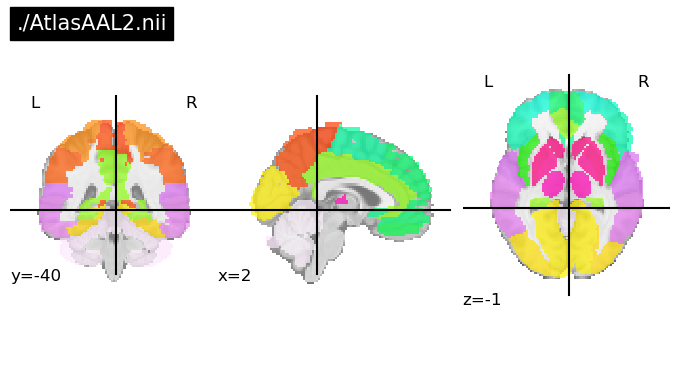

In [4]:
plotting.plot_roi(atlas, title=atlas)
plotting.show()

In this TP we will use Decision Trees, Bagging and Random Forests. Let's start with Decision Trees. First of all, we need to create a training and test set.

In [5]:
# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0, stratify=y
)

And then we need to check whether out features need to be standardized or normalized. Let's have a look at them. Remember that if features can have both negative and positive values, as a rule of thumb, they should be standardized. If they only have positive values, a normalization is usually used. 

As already said, please remember that you should learn the standardization/normalization (namely learn the average/std or the max/min values) ONLY in the training set and then use the same values also in the test set. You should NOT use the entire dataset (both training and test) for standardization/normalization. Otherwise, you would have a *data leakage*, namely you would use data (the test set) that you should not use during training. 

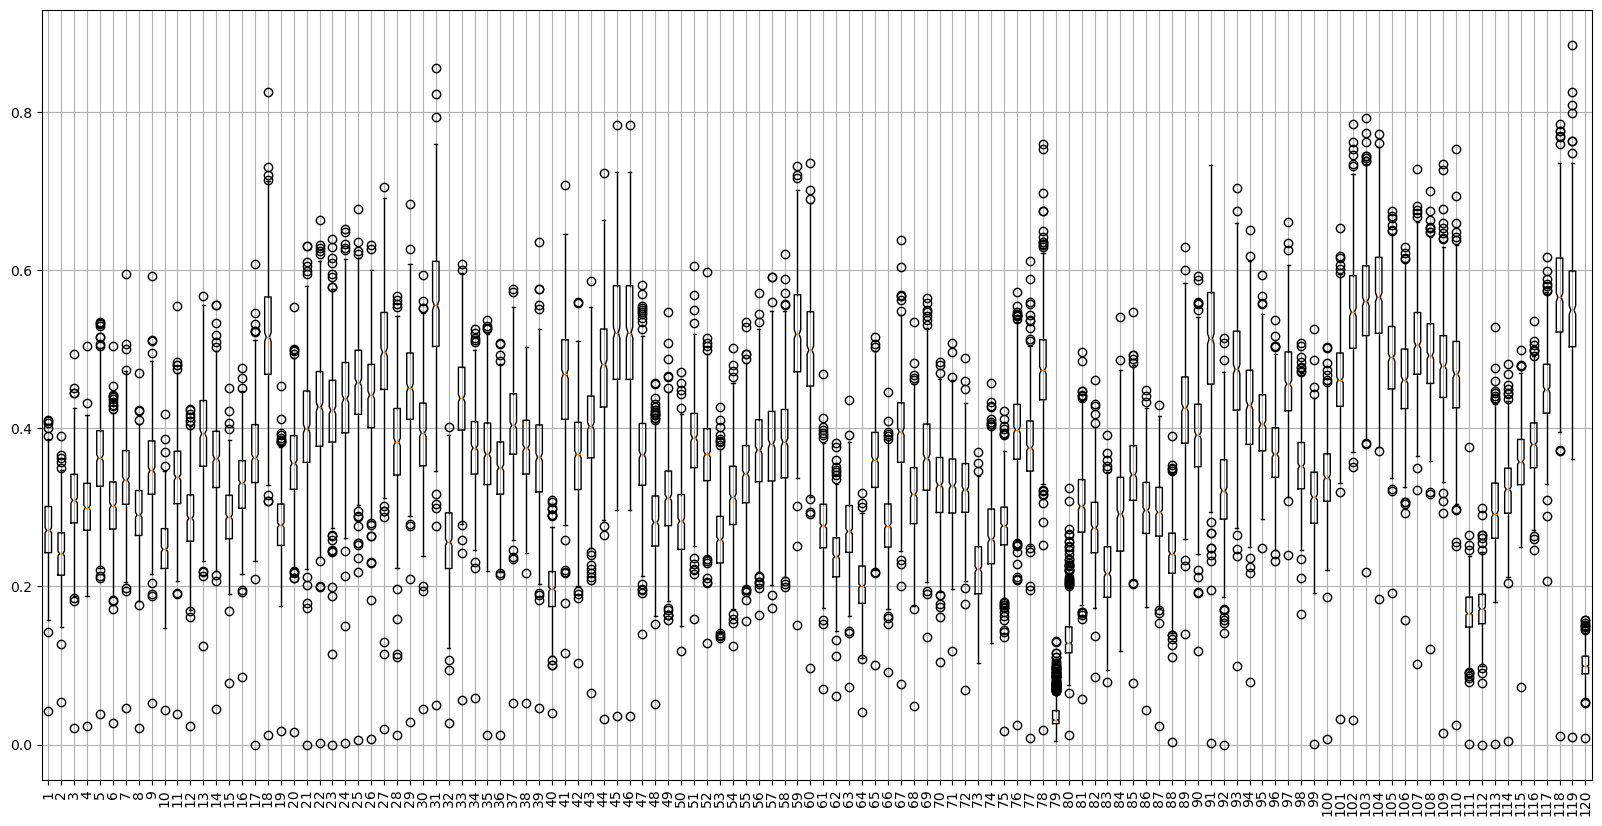

In [6]:
plt.figure(figsize=(20, 10))
plt.boxplot(X, notch=True)
plt.xticks(fontsize=10, rotation=90)
plt.grid()

# Standardization/Normalization
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

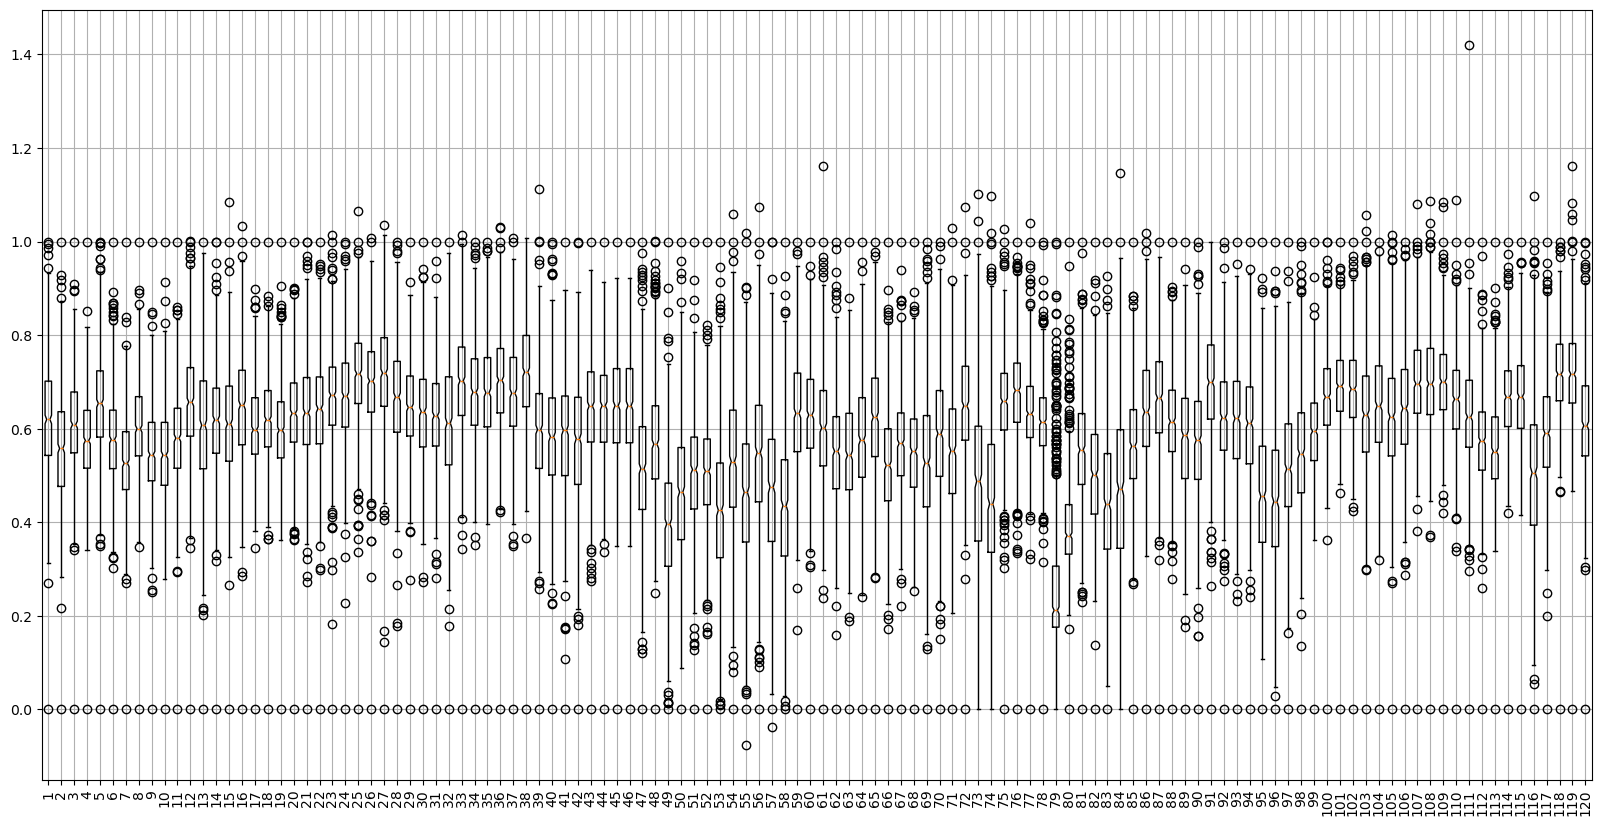

In [7]:
plt.figure(figsize=(20, 10))
plt.boxplot(np.vstack((X_train, X_test)), notch=True)
plt.xticks(fontsize=10, rotation=90)
plt.grid()

Then, we can fit a Decision tree, with the default setting, using the following code:

In [8]:
# Fitting Decision Trees
Tree = DecisionTreeClassifier(random_state=0)
Tree.fit(X_train, y_train)
# Score in the training set
print("Score in the training set is {0}".format(Tree.score(X_train, y_train)))
# Score in the test set
print("Score in the test set is {0}".format(Tree.score(X_test, y_test)))

Score in the training set is 1.0
Score in the test set is 0.7345132743362832


Instead than using the default hyperparameters, we could also look for the best ones. Among the hyperparameters implemented in *scikit-learn* we could use `min_samples_split`, the minimum number of samples required to split an internal node, and/or `min_samples_leaf`, the minimum number of samples required to be present at a leaf node. A split point at any depth will only be considered if it leaves at least `min_samples_leaf` training samples in each of the left and right branches. 

Plot the training and test score for different values of `min_samples_split` (for instance between 2 and 15) WITHOUT using Cross Validation. Do the same for `min_samples_leaf`.

**Question:** What is the best value ? What happens if you split differently your data (change `random_state`in the function `train_test_split`) ? 


**Answer**:

The optimal parameter values are influenced by the `random_state` set in the `train_test_split` function. Through numerous trials, it appears that the most effective parameters typically fall within the range of 2 to 5 for `min_samples_split` and 10 to 12 for `min_samples_leaf`. Specifically, when `random_state=0`, the highest generalization performance (test score) is achieved with `min_samples_split=5` and `min_samples_leaf=11`.

Adjusting parameters such as `min_samples_leaf` and `min_samples_split` can effectively mitigate overfitting by imposing constraints on the minimum number of samples required for leaf nodes and node splitting, respectively. Increasing these parameters helps to limit the complexity of the tree, preventing it from capturing noise or outliers in the training data. However, setting these values too high may lead to underfitting, where important patterns in the data are overlooked.

The value of min_samples_split that maximizes the training score is :  2
The value of min_samples_split that maximizes the test score is :  5


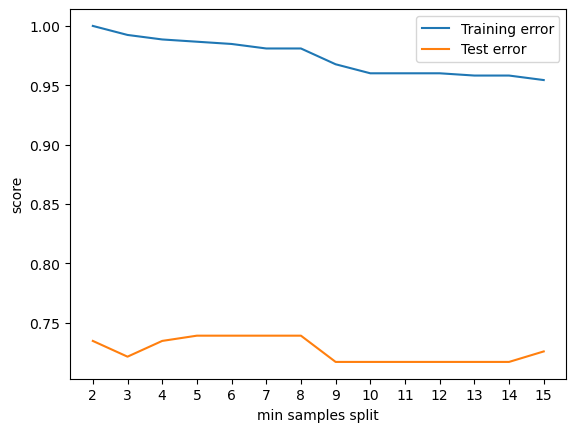

In [9]:
# min_samples_split

TTest = []
TTrain = []
for i in range(2, 16):
    Tree = DecisionTreeClassifier(min_samples_split=i, random_state=0)
    Tree.fit(X_train, y_train)
    scoreTrain = Tree.score(X_train, y_train)
    scoreTest = Tree.score(X_test, y_test)
    TTrain.append(scoreTrain)
    TTest.append(scoreTest)
plt.plot(TTrain, label="Training error")
plt.xticks(
    np.arange(14),
    ("2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15"),
)
print(
    "The value of min_samples_split that maximizes the training score is : ",
    TTrain.index(max(TTrain)) + 2,
)
plt.plot(TTest, label="Test error")
plt.xticks(
    np.arange(14),
    ("2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15"),
)
plt.xlabel("min samples split")
plt.ylabel("score")
print(
    "The value of min_samples_split that maximizes the test score is : ",
    TTest.index(max(TTest)) + 2,
)
plt.legend()
plt.show()

The value of min_samples_leaf that maximizes the training score is :  2
The value of min_samples_leaf that maximizes the test score is :  11


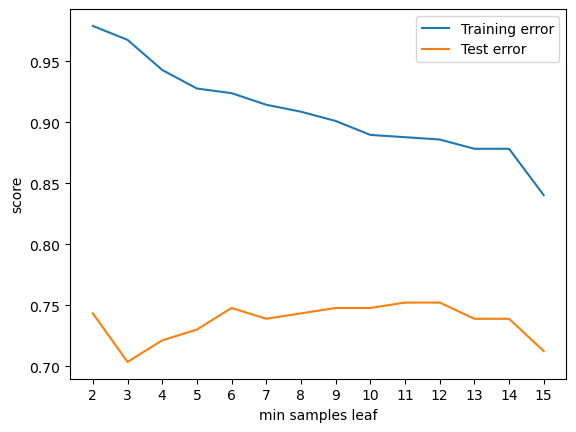

In [10]:
# min_samples_leaf

TTest = []
TTrain = []
for i in range(2, 16):
    Tree = DecisionTreeClassifier(min_samples_leaf=i, random_state=0)
    Tree.fit(X_train, y_train)
    scoreTrain = Tree.score(X_train, y_train)
    scoreTest = Tree.score(X_test, y_test)
    TTrain.append(scoreTrain)
    TTest.append(scoreTest)
plt.plot(TTrain, label="Training error")
plt.xticks(
    np.arange(14),
    ("2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15"),
)
print(
    "The value of min_samples_leaf that maximizes the training score is : ",
    TTrain.index(max(TTrain)) + 2,
)
plt.plot(TTest, label="Test error")
plt.xticks(
    np.arange(14),
    ("2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15"),
)
plt.xlabel("min samples leaf")
plt.ylabel("score")
print(
    "The value of min_samples_leaf that maximizes the test score is : ",
    TTest.index(max(TTest)) + 2,
)
plt.legend()
plt.show()

Try to add Gaussian noise to the data (using for instance zero mean and 0.05 for $\sigma$) and, using the best hyperparameters found before in the test set (you can use both `min_samples_leaf` and `min_samples_split`), look at the test score. Repeat this process several times and compare the results with the score obtained without adding noise. 

**Question**: Are the results stable ? Hint: you could use for instance `noise = np.random.normal(mu, sigma)` if you have standardized the features and `noise = np.abs(np.random.normal(mu, sigma))` if you have normalized them (we use`np.abs()` to take only positive values and $\sigma$ should be small in order to (almost) preserve the range of the features between 0 and 1)

**Answer:**

The results are not stable.

Decision trees exhibit low bias and high variance due to their hierarchical nature, which can lead to instability, particularly in noisy datasets. Their flexibility allows them to capture complex relationships but makes them sensitive to small variations in the data, resulting in different trees being generated for slightly altered datasets.

This instability arises from the hierarchical decision-making process, where small changes in input data can lead to entirely different splits and decision boundaries. To address this, ensemble methods like Random Forests and Gradient Boosting are often employed to reduce variance and improve stability, along with pruning techniques to mitigate overfitting and enhance generalization performance.

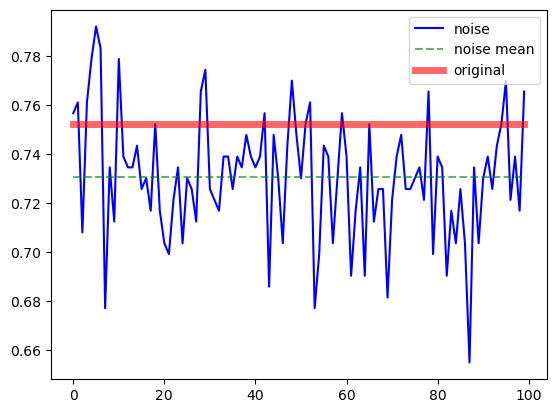

In [11]:
Tree = DecisionTreeClassifier(min_samples_split=5, min_samples_leaf=11, random_state=0)
scoreTestnoise = np.zeros(100)
scoreTest = np.zeros(100)

Tree.fit(X_train, y_train)
scoreTest[:] = Tree.score(X_test, y_test)

for k in range(100):
    X_train_temp = np.copy(X_train)
    for i in range(X_train.shape[0]):
        mu = 0
        sigma = 0.05
        noise = np.abs(np.random.normal(mu, sigma))
        X_train_temp[i] += noise

    Tree.fit(X_train_temp, y_train)
    scoreTestnoise[k] = Tree.score(X_test, y_test)

plt.plot(scoreTestnoise, "b", label="noise")
plt.plot(np.ones(100) * np.mean(scoreTestnoise), "g--", alpha=0.6, label="noise mean")
plt.plot(scoreTest, "r", linewidth=5.0, alpha=0.6, label="original")
plt.legend()
plt.show()

To plot decision trees, we can also use the *graphviz* library. If you need to install it locally, you can do it using *conda install python-graphviz*. 
 

First plot the tree learnt on the original data, witout adding noise.

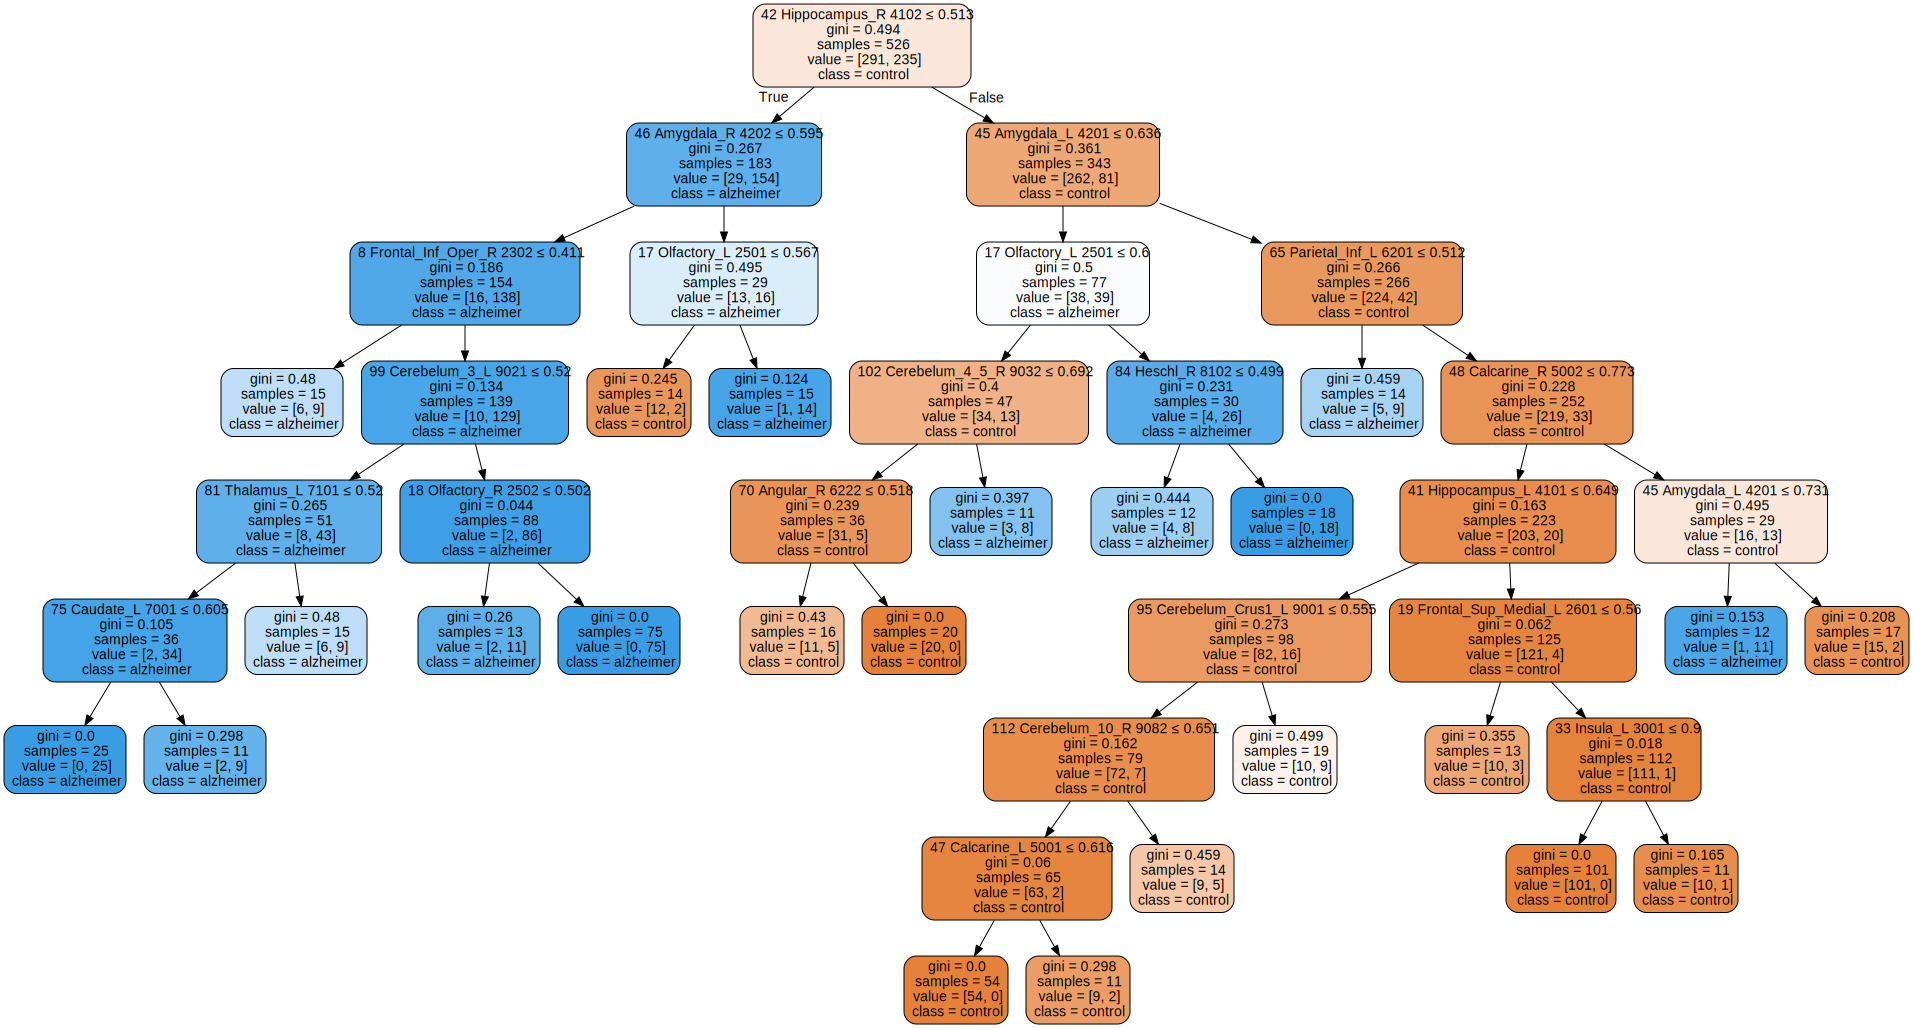

In [12]:
import graphviz

Tree = DecisionTreeClassifier(min_samples_split=5, min_samples_leaf=11, random_state=0)
Tree.fit(X_train, y_train)
dot_data = tree.export_graphviz(
    Tree,
    out_file=None,
    feature_names=labels,
    class_names=class_names,
    filled=True,
    rounded=True,
    special_characters=True,
)
graph = graphviz.Source(dot_data)
graph

Now, plot the tree learnt on noisy data.

**Question**: Is it the same ? You can try several times, for different levels of noise. Comment the results

**Answer**:

The decision tree derived from noisy data differs from the one built from clean data, with discrepancies primarily concentrated near the leaf nodes for minor noise and extending towards the root for higher noise levels, consequently affecting subsequent nodes. This discrepancy stems from the inherent low bias and high variance of decision trees, whereby their flexibility allows for fine-tuning to intricate patterns but also renders them susceptible to minor fluctuations in the input data, leading to significant changes in the resulting tree structure.

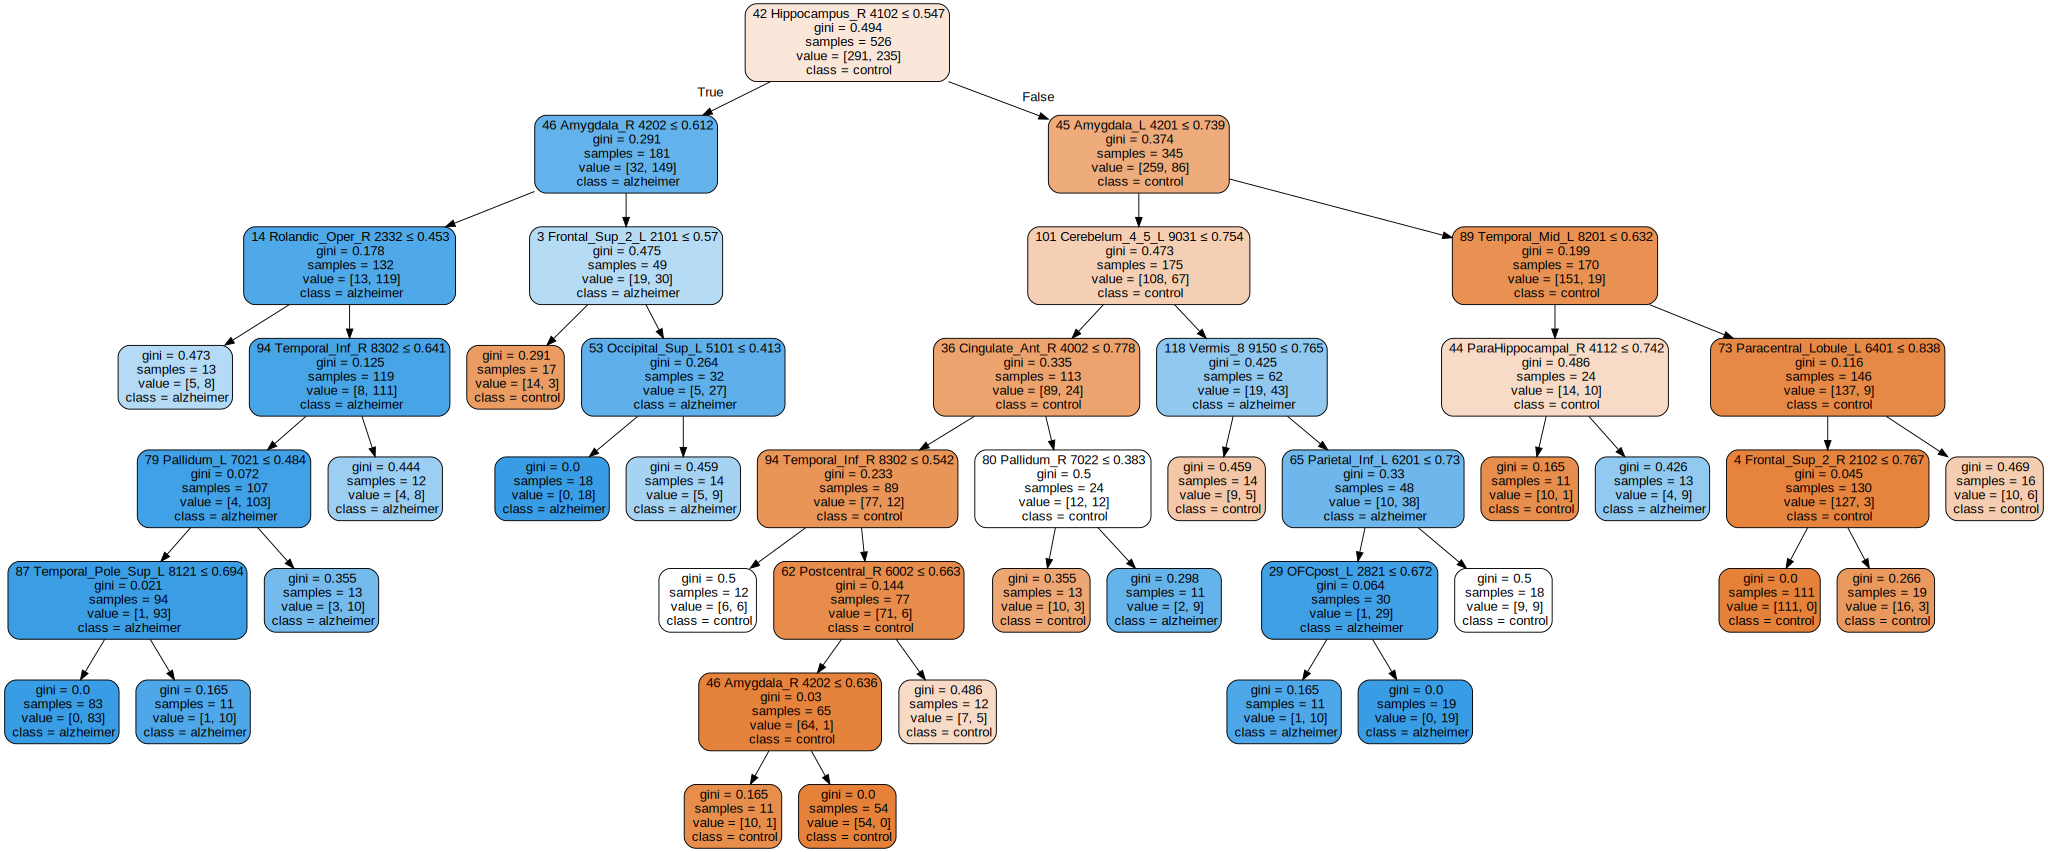

In [13]:
X_train_temp = np.copy(X_train)
for i in range(X_train.shape[0]):
    mu = 0
    sigma = 0.05
    noise = np.abs(np.random.normal(mu, sigma))
    X_train_temp[i] += noise

Tree = DecisionTreeClassifier(min_samples_split=5, min_samples_leaf=11, random_state=0)
Tree.fit(X_train_temp, y_train)
dot_data = tree.export_graphviz(
    Tree,
    out_file=None,
    feature_names=labels,
    class_names=class_names,
    filled=True,
    rounded=True,
    special_characters=True,
)
graph = graphviz.Source(dot_data)
graph

Instead than using a single split of the data, we could also use Cross Validation to compute the best hyperparameter values for both `min_samples_split` and `min_samples_leaf` at the same time and in an automatic way. 

**Question:** Do you find the same optimal hyperparameters as before ? Hint: use GridSearchCV

**Question**: So far, we have used the standard score (ie accuracy). Would you use a different one ? If yes, which one and why ?

**Answer**:

The hyperparameters discovered via GridSearch differ from those discovered before, as the cross-validation splits enable more extensive and robust generalization across the dataset by evaluating multiple splits. Presently, the optimal parameters determined are a minimum sample split of 2 and a minimum sample leaf size of 14.

**Answer**:

Considering alternative scoring metrics, like F1, could potentially encourage the model to account for class balance. Nonetheless, in this scenario, there isn't a noticeable enhancement in results and the best hyperparameters doesn't differ from those determined by using accuracy as a scoring metric, suggesting that the classes are likely already well balanced. Hence, utilizing the standard accuracy metric remains appropriate as it is easier to interpret. Changing the `random_state` does not affect the result as we used the parameter `stratify` in `train_test_split` to ensure that classes proportions remained the same as originally.

In [14]:
Tree = DecisionTreeClassifier(random_state=0)
p_grid_tree = {
    "min_samples_split": [i for i in range(2, 16)],
    "min_samples_leaf": [i for i in range(2, 16)],
}
grid_tree = GridSearchCV(Tree, p_grid_tree, cv=5, scoring="accuracy")
grid_tree.fit(X_train, y_train)
print("Best Validation Score: {}".format(grid_tree.best_score_))
print("Best params: {}".format(grid_tree.best_params_))
print("Tree test score :", grid_tree.score(X_test, y_test))

best_params = grid_tree.best_params_

Best Validation Score: 0.7680682839173406
Best params: {'min_samples_leaf': 14, 'min_samples_split': 2}
Tree test score : 0.7389380530973452


In [15]:
Tree = DecisionTreeClassifier(random_state=0)
p_grid_tree = {
    "min_samples_split": [i for i in range(2, 16)],
    "min_samples_leaf": [i for i in range(2, 16)],
}
grid_tree = GridSearchCV(Tree, p_grid_tree, cv=5, scoring="f1")
grid_tree.fit(X_train, y_train)
print("Best Validation Score: {}".format(grid_tree.best_score_))
print("Best params: {}".format(grid_tree.best_params_))
print("Tree test score :", grid_tree.score(X_test, y_test))

best_params = grid_tree.best_params_

Best Validation Score: 0.7329557753574452
Best params: {'min_samples_leaf': 14, 'min_samples_split': 2}
Tree test score : 0.6974358974358975


Using the estimated optimal hyperparameers, plot the new decision tree using the *graphviz* library. 

**Question**: Is it the same as before? Do you see ROIs that are always close to the root of the tree among the different experiments ? If yes, what does it mean in your opinion ? Comment the results.

**Answer**:

The decision tree constructed using the parameters determined by GridSearch closely resembles the tree trained on the original dataset.

Notably, a significant number of Regions of Interest (ROIs) consistently appear near the root across various experiments, such as "42 Hippocampus_R 4102", "46 Amygdala_R 4202", "45 Amygdala_L 4201", among others. This consistency suggests that the model identifies these parameters as pivotal for the classification task, as they effectively delineate the data into splits that best represent decision boundaries. Consequently, these features likely exhibit strong correlations with the classification classes, indicating their importance in the predictive modeling process.

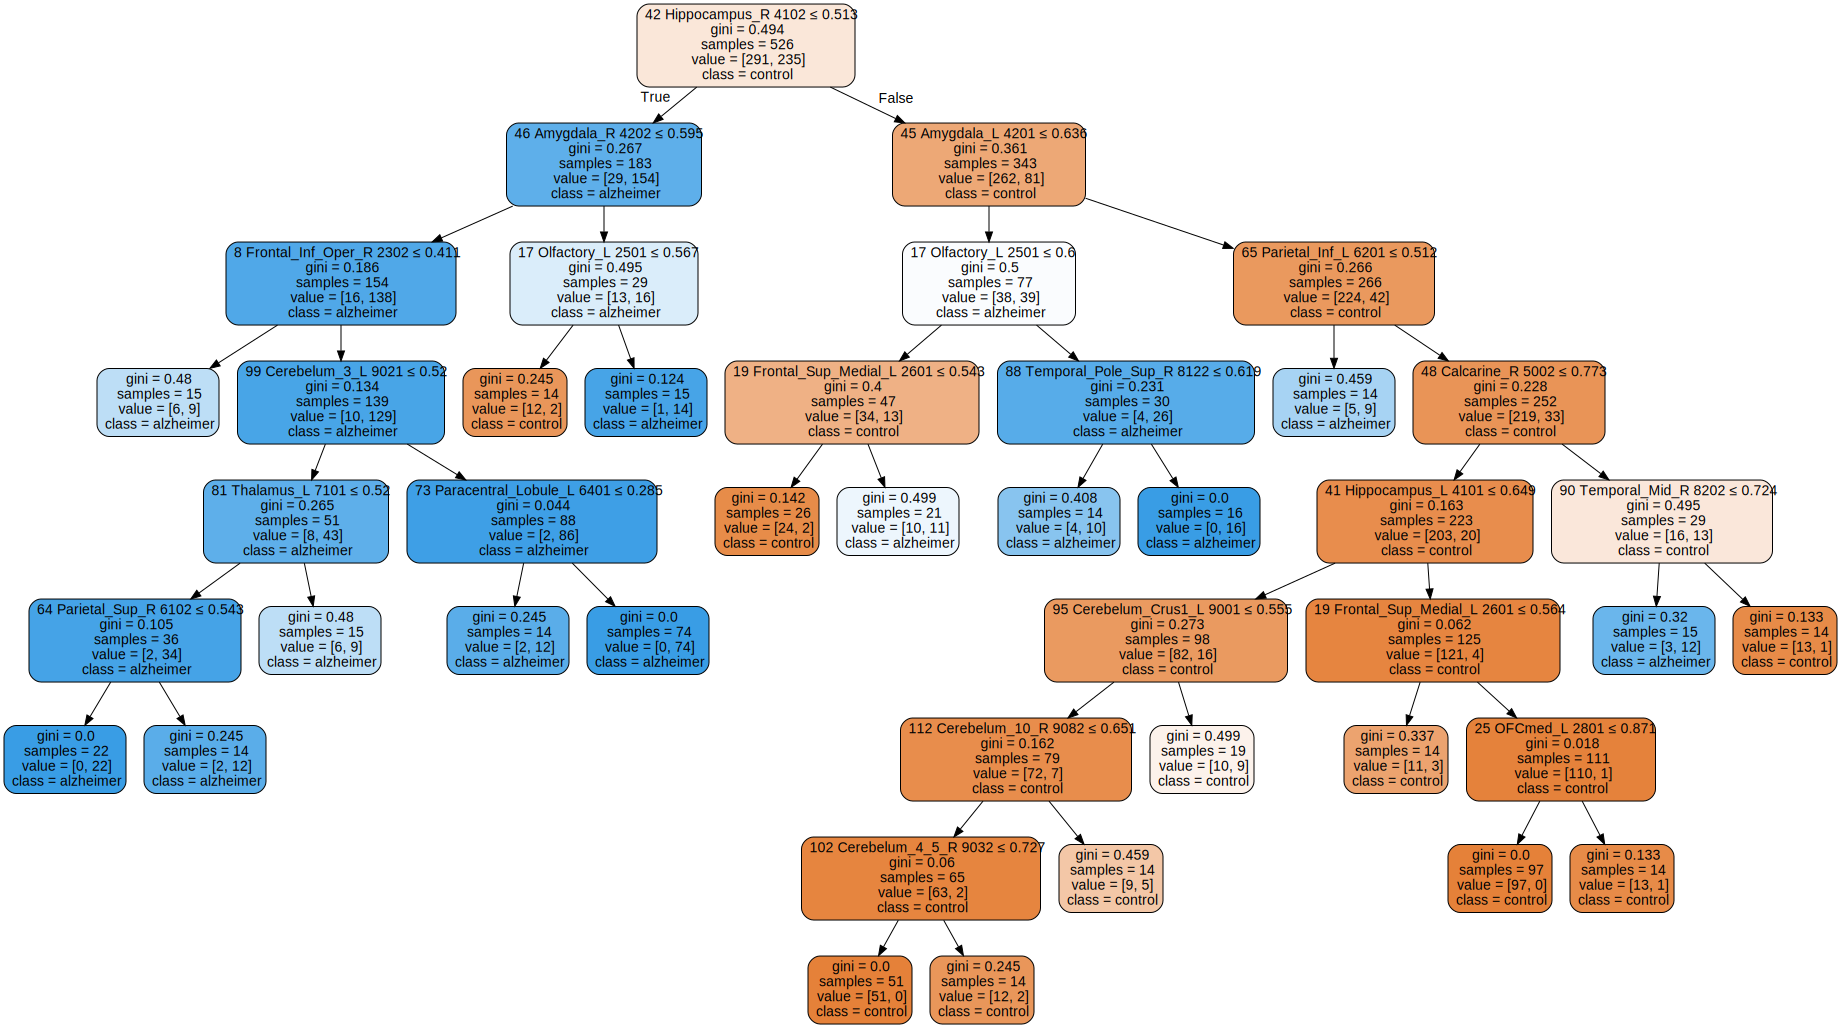

In [16]:
Tree = DecisionTreeClassifier(
    min_samples_split=best_params["min_samples_split"],
    min_samples_leaf=best_params["min_samples_leaf"],
    random_state=0,
)
Tree.fit(X_train, y_train)
dot_data = tree.export_graphviz(
    Tree,
    out_file=None,
    feature_names=labels,
    class_names=class_names,
    filled=True,
    rounded=True,
    special_characters=True,
)
graph = graphviz.Source(dot_data)
graph

Try to use now Bagging. You can use the following code where we use the previously computed best parameters 'min_samples_leaf' and 'min_samples_split'. 

**Question**: What happens when you use the original data and the noisy version ? Do you notice any difference in the prediction scores with respect to the results using Decision Trees ? 

**Answer**:

Adding noise before bagging in the context of decision trees enhances the ensemble model's robustness and generalization by introducing randomness, diversifying the trees, controlling overfitting, and stabilizing the ensemble. This can be seen by the increased test score. The noise helps prevent individual trees from overfitting to specific patterns in the training data, leading to a more generalized model that performs better on unseen data. While interpretability of individual trees may be slightly compromised due to the noise, the overall predictive performance of the ensemble typically improves as a result of reduced variance and increased model stability. However, the amount of noise added should be carefully tuned to strike a balance between improving robustness and maintaining interpretability.

In [17]:
Tree = DecisionTreeClassifier(
    min_samples_leaf=best_params["min_samples_leaf"],
    min_samples_split=best_params["min_samples_split"],
    random_state=0,
)

p_grid_bagging = {"n_estimators": [5, 10, 15, 20]}
bag = BaggingClassifier(estimator=Tree, random_state=0)
grid_bagging = GridSearchCV(estimator=bag, param_grid=p_grid_bagging)
grid_bagging.fit(X_train, y_train.ravel())
print("Best Validation Score: {}".format(grid_bagging.best_score_))
print("Best params: {}".format(grid_bagging.best_params_))
print("Bagging test score :", grid_bagging.score(X_test, y_test))

Best Validation Score: 0.8022461814914645
Best params: {'n_estimators': 20}
Bagging test score : 0.7787610619469026


In [18]:
# Bagging on noisy data

Tree = DecisionTreeClassifier(
    min_samples_leaf=best_params["min_samples_leaf"],
    min_samples_split=best_params["min_samples_split"],
    random_state=0,
)

p_grid_bagging = {"n_estimators": [5, 10, 15, 20]}
bag = BaggingClassifier(estimator=Tree, random_state=0)
grid_bagging = GridSearchCV(estimator=bag, param_grid=p_grid_bagging)
grid_bagging.fit(X_train_temp, y_train.ravel())
print("Best Validation Score: {}".format(grid_bagging.best_score_))
print("Best params: {}".format(grid_bagging.best_params_))
print("Bagging test score :", grid_bagging.score(X_test, y_test))

Best Validation Score: 0.8079604672057503
Best params: {'n_estimators': 20}
Bagging test score : 0.7876106194690266


The last part of this TP is about Random Forests. We can estimate the three hyperparameters `n_estimators`, `min_samples_leaf` and `max_features`, the number of features to consider when looking for the best split, as before using Cross Validation

In [19]:
RF = RandomForestClassifier(random_state=0)
p_grid_RF = {
    "n_estimators": [10, 15, 20, 25, 30],
    "min_samples_leaf": [2, 3, 4, 5, 6],
    "max_features": ["sqrt", "log2"],
}

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring="f1", cv=5)
grid_RF.fit(X_train, y_train.ravel())

print("Best Validation Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))
print("Random Forest test score :", grid_RF.score(X_test, y_test))

Best Validation Score: 0.7886868694658289
Best params: {'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 20}
Random Forest test score : 0.7724867724867726


Using the estimated best hyperparameters, test the performance of Random Forest on the noisy data and compare the results with Decision Trees and Bagging. 

In [20]:
# Random Forest on noisy data
RF = RandomForestClassifier(random_state=0)
p_grid_RF = {
    "n_estimators": [10, 15, 20, 25, 30],
    "min_samples_leaf": [2, 3, 4, 5, 6],
    "max_features": ["sqrt", "log2"],
}

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring="f1", cv=5)
grid_RF.fit(X_train_temp, y_train.ravel())

print("Best Validation Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))
print("Random Forest test score :", grid_RF.score(X_test, y_test))

Best Validation Score: 0.8028042510165007
Best params: {'max_features': 'log2', 'min_samples_leaf': 4, 'n_estimators': 30}
Random Forest test score : 0.7536231884057971


We can also use Random Forests to check the importance of the features

Feature ranking:
1. feature 44 representing 45 Amygdala_L 4201
 (0.076482)
2. feature 43 representing 44 ParaHippocampal_R 4112
 (0.060960)
3. feature 45 representing 46 Amygdala_R 4202
 (0.055017)
4. feature 40 representing 41 Hippocampus_L 4101
 (0.051967)
5. feature 92 representing 93 Temporal_Inf_L 8301
 (0.040495)
6. feature 93 representing 94 Temporal_Inf_R 8302
 (0.033461)
7. feature 41 representing 42 Hippocampus_R 4102
 (0.030225)
8. feature 42 representing 43 ParaHippocampal_L 4111
 (0.024354)
9. feature 86 representing 87 Temporal_Pole_Sup_L 8121
 (0.022777)
10. feature 67 representing 68 SupraMarginal_R 6212
 (0.017762)


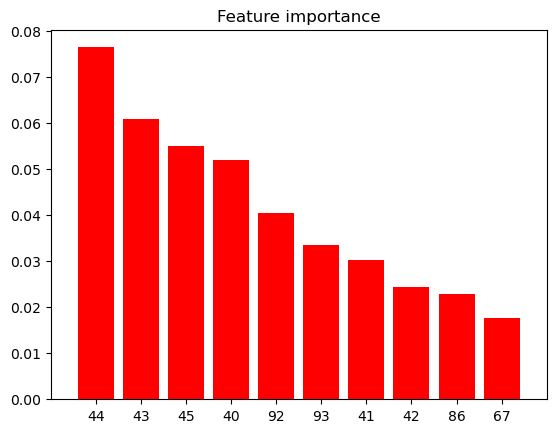

In [21]:
best_params = grid_RF.best_params_
RF = RandomForestClassifier(
    min_samples_leaf=best_params["min_samples_leaf"],
    max_features=best_params["max_features"],
    n_estimators=best_params["n_estimators"],
    random_state=0,
)
RF.fit(X_train, y_train.ravel())

importances = RF.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print(
        "%d. feature %d representing %s (%f)"
        % (f + 1, indices[f], labels[indices[f]], importances[indices[f]])
    )

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importance")
plt.bar(range(10), importances[indices[0:10]], color="r", align="center")
plt.xticks(range(10), indices[0:10])
plt.xlim([-1, 10])
plt.show()

**Question**: Which are the most important features (i.e. ROIs) ?  Based on the two given research papers, you can verify if your results make sense. 

**Answer**:

The two most significant features according to the created model, ranked in order, are feature 45 "46 Amygdala_R 4202" and feature 43 "44 ParaHippocampal_R 4112". Research papers corroborate the significance of the Amygdala_R and Hippocampus_L in this context, which is in accordance to the obtained results.

We can also inspect the data using only pairs of the most important features

For pair [44, 43], testing score: 0.7212389380530974
For pair [44, 45], testing score: 0.7035398230088495
For pair [44, 40], testing score: 0.7168141592920354
For pair [43, 45], testing score: 0.7212389380530974
For pair [43, 40], testing score: 0.7256637168141593
For pair [45, 40], testing score: 0.7168141592920354


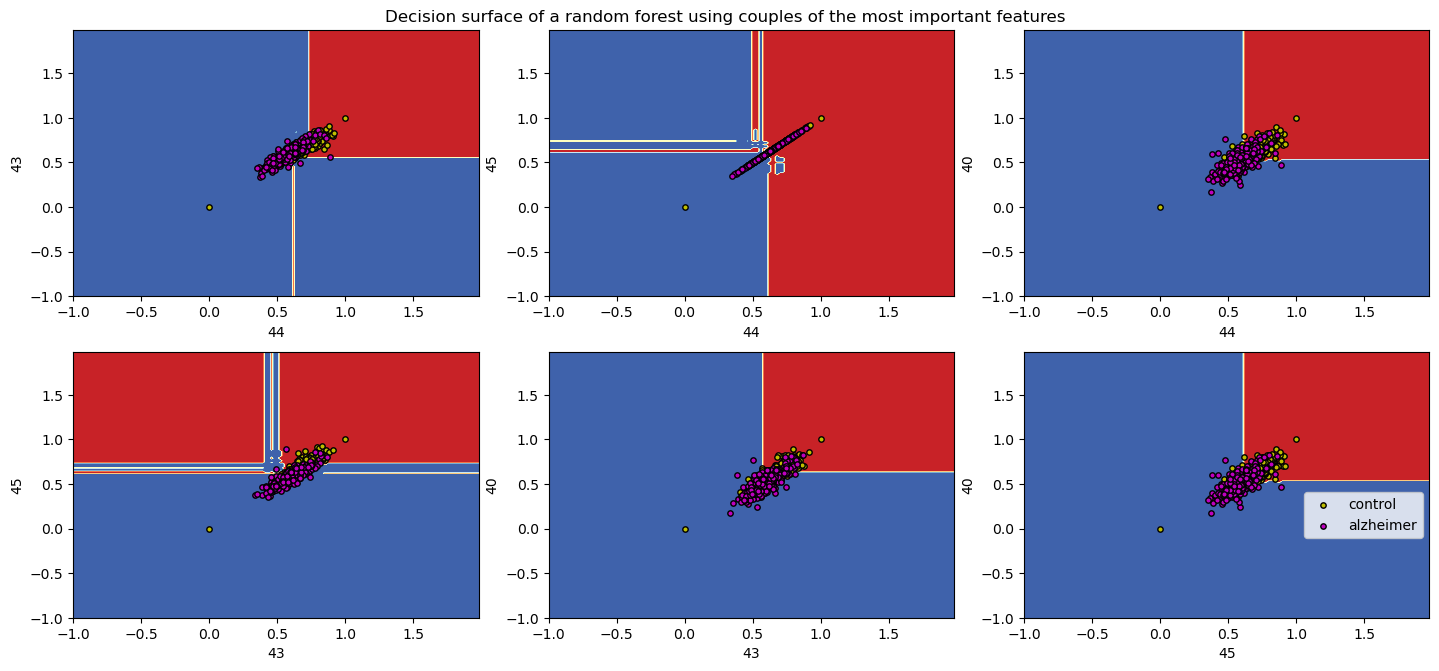

In [22]:
plt.figure(figsize=(15, 7))
for pairidx, pair in enumerate(
    [
        [indices[0], indices[1]],
        [indices[0], indices[2]],
        [indices[0], indices[3]],
        [indices[1], indices[2]],
        [indices[1], indices[3]],
        [indices[2], indices[3]],
    ]
):
    # We only take the two corresponding features
    Xpair = X_train[:, pair]
    ypair = y_train

    # Train
    clf = RF.fit(Xpair, ypair.ravel())
    print(f"For pair {pair}, testing score: {clf.score(X_test[:, pair], y_test)}")

    # Plot the decision boundary
    plt.subplot(2, 3, pairidx + 1)

    x_min, x_max = Xpair[:, 0].min() - 1, Xpair[:, 0].max() + 1
    y_min, y_max = Xpair[:, 1].min() - 1, Xpair[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

    plt.xlabel(pair[0])
    plt.ylabel(pair[1])

    # Plot the training points
    for i, color in zip(range(2), "ym"):
        idx = np.where(ypair == i)
        plt.scatter(
            Xpair[idx, 0],
            Xpair[idx, 1],
            c=color,
            label=class_names[i],
            # cmap=plt.cm.RdYlBu,
            edgecolor="black",
            s=15,
        )

plt.suptitle(
    "Decision surface of a random forest using couples of the most important features"
)
plt.legend(bbox_to_anchor=(1, 0.5))
plt.axis("tight")
plt.show()

**Question**: Which is the best couple of features ?

**Answer**:

All pairs of features yielded comparable and considerably good results. However, the pair which yielded the best test score is 43-40, which corresponds to ROI ParaHippocampal_R 4112 and Hippocampus_L 4101. This means that these features, together, are an effective representation of the variability present in the original dataset.

**Different Atlas**

Previously, we have used the AAL2 which defines a precise split of the brain into ROIs. What happens if you change Atlas ? Do you obtain the same results ? Can you find a subset of ROIs that you could define 'biomarkers' of the Alzheimer's disease ? Justify your answer and check whether it makes sense by using the two given research papers.

You can use the AICHA (http://www.gin.cnrs.fr/fr/outils/aicha/) and HAMMERS (https://brain-development.org/brain-atlases/adult-brain-atlases/) atlas.

**Answer**:

HAMMERS yielded outcomes akin to AAL2, predominantly highlighting the amygdala and hippocampus as pivotal features, as evidenced in the referenced paper. In contrast, AICHA presented disparate findings, assigning significance to S_Parietooccipital, Thalamus, and Fusiform regions. While one paper underscores the importance of the Thalamus, corroborating evidence regarding the significance of the remaining features appears elusive.

Number of controls and Alzheimer patients is respectively: 416.0 and 336.0
Number of ROI (features) is: 192


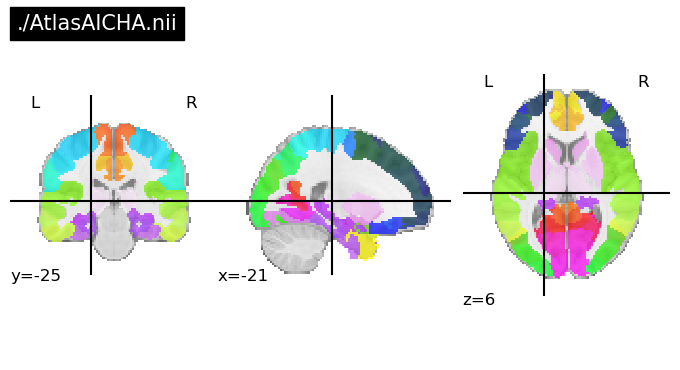

Best Validation Score: 0.69524802828933
Best params: {'max_features': 'sqrt', 'min_samples_leaf': 4, 'n_estimators': 30}
Random Forest test score : 0.6754385964912281
Feature ranking:
1. feature 144 representing 145	S_Parietooccipital-4	146
 (0.074652)
2. feature 188 representing 189	N_Thalamus-6	190
 (0.048999)
3. feature 187 representing 188	N_Thalamus-5	189
 (0.035493)
4. feature 172 representing 173	N_Amygdala-1	174
 (0.025304)
5. feature 189 representing 190	N_Thalamus-7	191
 (0.025265)
6. feature 170 representing 171	G_Fusiform-6	172
 (0.021396)
7. feature 180 representing 181	N_Pallidum-1	182
 (0.019268)
8. feature 145 representing 146	S_Parietooccipital-5	147
 (0.018559)
9. feature 182 representing 183	N_Putamen-3	184
 (0.015761)
10. feature 191 representing 192	N_Thalamus-9	193
 (0.015450)


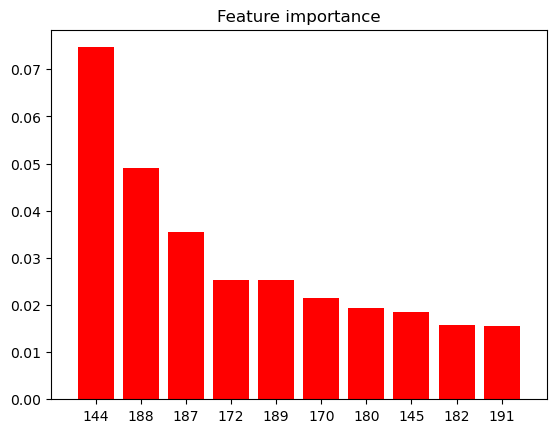

In [23]:
# Choose Atlas (here AAL2)
X = T1AICHA  # T1AAL2, T1AICHA, T1HAMMERS
labels = ROIlabelsAICHA  # ROIlabelsAAL2, ROIlabelsAICHA, ROIlabelsHAMMERS
atlas = "./AtlasAICHA.nii"  # AtlasAAL2.nii, AtlasAICHA.nii, AtlasHAMMERS.nii

N, M = X.shape  # number subjects and ROIs
class_names = ["control", "alzheimer"]  # y=0, y=1

print(
    "Number of controls and Alzheimer patients is respectively: {0} and {1}".format(
        N - np.sum(y), np.sum(y)
    )
)
print("Number of ROI (features) is: {0}".format(M))

plotting.plot_roi(atlas, title=atlas)
plotting.show()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0, stratify=y
)

X_train_temp = np.copy(X_train)
for i in range(X_train.shape[0]):
    mu = 0
    sigma = 0.05
    noise = np.abs(np.random.normal(mu, sigma))
    X_train_temp[i] += noise

# Random Forest on noisy data
RF = RandomForestClassifier(random_state=0)
p_grid_RF = {
    "n_estimators": [10, 15, 20, 25, 30],
    "min_samples_leaf": [2, 3, 4, 5, 6],
    "max_features": ["sqrt", "log2"],
}

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring="f1", cv=5)
grid_RF.fit(X_train_temp, y_train.ravel())

print("Best Validation Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))
print("Random Forest test score :", grid_RF.score(X_test, y_test))

best_params = grid_RF.best_params_
RF = RandomForestClassifier(
    min_samples_leaf=best_params["min_samples_leaf"],
    max_features=best_params["max_features"],
    n_estimators=best_params["n_estimators"],
    random_state=0,
)
RF.fit(X_train, y_train.ravel())

importances = RF.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print(
        "%d. feature %d representing %s (%f)"
        % (f + 1, indices[f], labels[indices[f]], importances[indices[f]])
    )

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importance")
plt.bar(range(10), importances[indices[0:10]], color="r", align="center")
plt.xticks(range(10), indices[0:10])
plt.xlim([-1, 10])
plt.show()

Number of controls and Alzheimer patients is respectively: 416.0 and 336.0
Number of ROI (features) is: 68


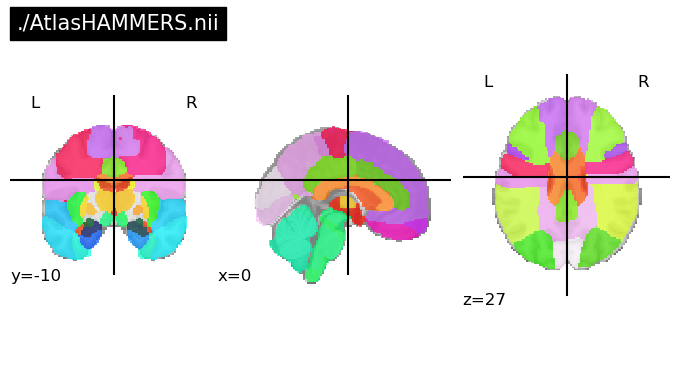

Best Validation Score: 0.7761578074816285
Best params: {'max_features': 'sqrt', 'min_samples_leaf': 4, 'n_estimators': 30}
Random Forest test score : 0.76
Feature ranking:
1. feature 3 representing Right Amygdala                         (0.123333)
2. feature 2 representing Left Amygdala                          (0.083571)
3. feature 0 representing Left Hippocampus                       (0.076214)
4. feature 1 representing Right Hippocampus                      (0.054858)
5. feature 46 representing Left Lateral Temporal Ventricle        (0.047053)
6. feature 12 representing Left Inferior Middle Temporal Gyri     (0.042156)
7. feature 5 representing Right Anterior Medial Temporal Lobe    (0.031651)
8. feature 4 representing Left Anterior Medial Temporal Lobe     (0.027874)
9. feature 8 representing Left Ambient and Parahippocampus Gyri  (0.021312)
10. feature 40 representing Left Thalamus                          (0.019380)


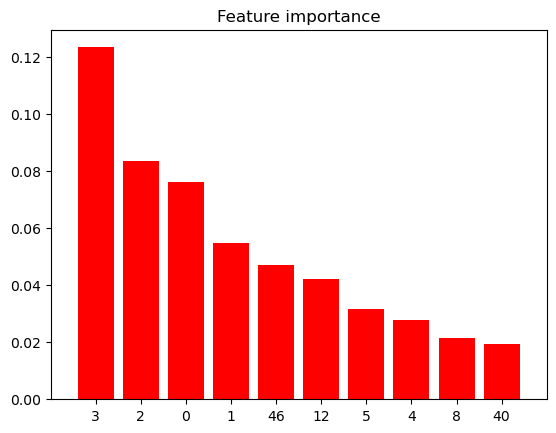

In [24]:
# Choose Atlas (here AAL2)
X = T1HAMMERS  # T1AAL2, T1AICHA, T1HAMMERS
labels = ROIlabelsHAMMERS  # ROIlabelsAAL2, ROIlabelsAICHA, ROIlabelsHAMMERS
atlas = "./AtlasHAMMERS.nii"  # AtlasAAL2.nii, AtlasAICHA.nii, AtlasHAMMERS.nii

N, M = X.shape  # number subjects and ROIs
class_names = ["control", "alzheimer"]  # y=0, y=1

print(
    "Number of controls and Alzheimer patients is respectively: {0} and {1}".format(
        N - np.sum(y), np.sum(y)
    )
)
print("Number of ROI (features) is: {0}".format(M))

plotting.plot_roi(atlas, title=atlas)
plotting.show()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0, stratify=y
)

X_train_temp = np.copy(X_train)
for i in range(X_train.shape[0]):
    mu = 0
    sigma = 0.05
    noise = np.abs(np.random.normal(mu, sigma))
    X_train_temp[i] += noise

# Random Forest on noisy data
RF = RandomForestClassifier(random_state=0)
p_grid_RF = {
    "n_estimators": [10, 15, 20, 25, 30],
    "min_samples_leaf": [2, 3, 4, 5, 6],
    "max_features": ["sqrt", "log2"],
}

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring="f1", cv=5)
grid_RF.fit(X_train_temp, y_train.ravel())

print("Best Validation Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))
print("Random Forest test score :", grid_RF.score(X_test, y_test))

best_params = grid_RF.best_params_
RF = RandomForestClassifier(
    min_samples_leaf=best_params["min_samples_leaf"],
    max_features=best_params["max_features"],
    n_estimators=best_params["n_estimators"],
    random_state=0,
)
RF.fit(X_train, y_train.ravel())

importances = RF.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print(
        "%d. feature %d representing %s (%f)"
        % (f + 1, indices[f], labels[indices[f]], importances[indices[f]])
    )

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importance")
plt.bar(range(10), importances[indices[0:10]], color="r", align="center")
plt.xticks(range(10), indices[0:10])
plt.xlim([-1, 10])
plt.show()